# 3D AutoencoderKL

This demo is a toy example of how to use MONAI's AutoencoderKL. In particular, it uses the Autoencoder with a Kullback-Leibler regularisation as implemented by Rombach et. al [1]. The autoencoder was originally implemented by Kingma et al. [2]. The model uses the 3D brain tumour segmentation challenge (BraTS) [3] dataset available as part of the Decathlon Dataset.

[1] Rombach et. al "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/pdf/2112.10752.pdf<br>
[2] Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. CoRR, abs/1312.6.<br>
[3] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M.-A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694<br>

This tutorial was based on:

[Brain tumor 3D segmentation with MONAI](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb)

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

2024-12-03 18:16:32.808071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733249792.826516  195047 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733249792.832158  195047 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup environment

In [2]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

2024-12-03 18:16:44.496447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733249804.515816  195190 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733249804.521519  195190 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import monai
print(dir(monai.networks.nets))

/mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'AutoencoderKL', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'ControlNet', 'Critic', 'DAF3D', 'DecoderOnlyTransformer', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'DiffusionModelUNet', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MedNeXt', 'MedNeXtB', 'MedNeXtL', 'MedNeXtLarge', 'MedNeXtM', 'MedNeXtMedium', 'MedNeXtS', 'MedNeXtSmall', 'MedNext', 'MedNextB',

## Setup imports

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

MONAI version: 1.5.dev2447
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d6751b01bf78fddabe03b2c53645c6bc9808ed8
MONAI __file__: /mnt/nfs/home/<username>/anaconda3/envs/cardio/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.16.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
#root_dir = r"C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database"
#root_dir = '/mnt/nfs/home/liglesias/data_tgv'
#root_dir = '//atlas.bit.upm.es/BIT-UPM-projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc'

root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")

#training_dir = os.path.join(root_dir, "train")
#testing_dir = os.path.join(root_dir, "test")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing


(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


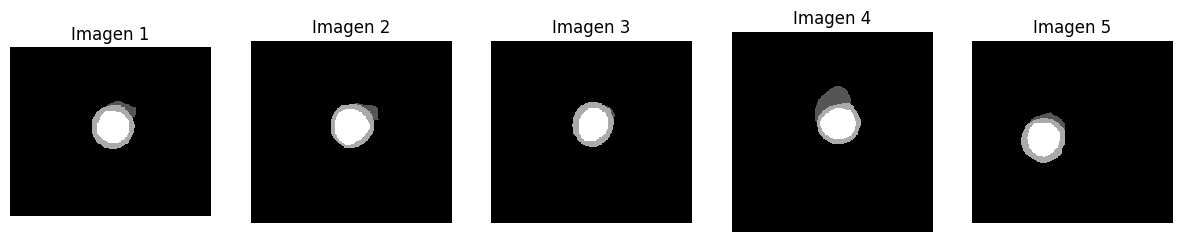

In [6]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [7]:
all_files = training_files + testing_files
images = [nib.load(file).get_fdata() for file in all_files]
image_shapes = [img.shape for img in images]
print(image_shapes)
average_shape = np.mean(image_shapes, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)

print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

## Set deterministic training for reproducibility

In [8]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

The brain tumour segmentation dataset is available as part of the Decathlon dataset. Select the channel (MRI contrast) you wish to use for training (0: FLAIR, 1: T1, 2: T1-PC, 3: T2). 
Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

We use the following transforms:
1. `LoadImaged`: retrieve the nii image
2. `EnsureChannelFirstd`: we ensure that the channel component is in dimension 0 of the tensor
3. `Lambdad`: this custom transform retrieves the specific channel that we desire
4. `EnsureChannelFirstd`: we add the new channel dimension (as the last transform has removed it)

In [9]:
# PREPARACIÓN DE LA IMAGEN MÉDICA
# Carga las imágenes y se asegura de que la imagen cargada tenga el canal de color en la primera dimensión
# Aplica una transformación personalizada a la imagen y garantiza que la imagen tenga el canal en la primera dimensión
# Asegura que tenga el tipo de datos adecuado, reorienta la imagen a un sist de coord específico
# Recorta la imagen a un tamaño específico y esscala la intensidad de la imagen

crop_size = (224, 224, 10)

all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.Lambdad(keys="image", func=lambda x: x[channel, :, :, :]),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="RAS"),
    #transforms.Spacingd(keys=["image"], pixdim=(2.4, 2.4, 2.2), mode=("bilinear")),
    transforms.Spacingd(keys=["image"], pixdim=(2.4, 2.4, 2.2), mode=("nearest")),
    #transforms.CenterSpatialCropd(keys=["image"], roi_size=(96, 96, 64)),
    transforms.CenterSpatialCropd(keys=["image"], roi_size=crop_size),
    #transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    transforms.Resized(keys=["image"], spatial_size=(154, 154, 6), mode=('nearest-exact')), 
]

In [10]:
# Crear un Dataset de MONAI para los archivos de entrenamiento y validación
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=all_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)

Now we create the training and validation loaders:

In [11]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([1, 154, 154, 6])
Image shape torch.Size([1, 154, 154, 6])


## Visualise examples from the training set

In [12]:
'''# Obtener los datos del primer lote del train_loader
check_data = first(train_loader)
# Select the first image from the batch
img = check_data["image"][0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[0, ..., img.shape[3] // 2].rot90(), cmap="gray")
ax = axs[1]
ax.imshow(img[0, :, img.shape[2] // 2, ...].rot90(), cmap="gray")
ax = axs[2]
ax.imshow(img[0, img.shape[1] // 2, ...].rot90(), cmap="gray")'''

'# Obtener los datos del primer lote del train_loader\ncheck_data = first(train_loader)\n# Select the first image from the batch\nimg = check_data["image"][0]\nfig, axs = plt.subplots(nrows=1, ncols=3)\nfor ax in axs:\n    ax.axis("off")\nax = axs[0]\nax.imshow(img[0, ..., img.shape[3] // 2].rot90(), cmap="gray")\nax = axs[1]\nax.imshow(img[0, :, img.shape[2] // 2, ...].rot90(), cmap="gray")\nax = axs[2]\nax.imshow(img[0, img.shape[1] // 2, ...].rot90(), cmap="gray")'

Imagen de entrenamiento cargada, tamaño: torch.Size([1, 1, 154, 154, 6])


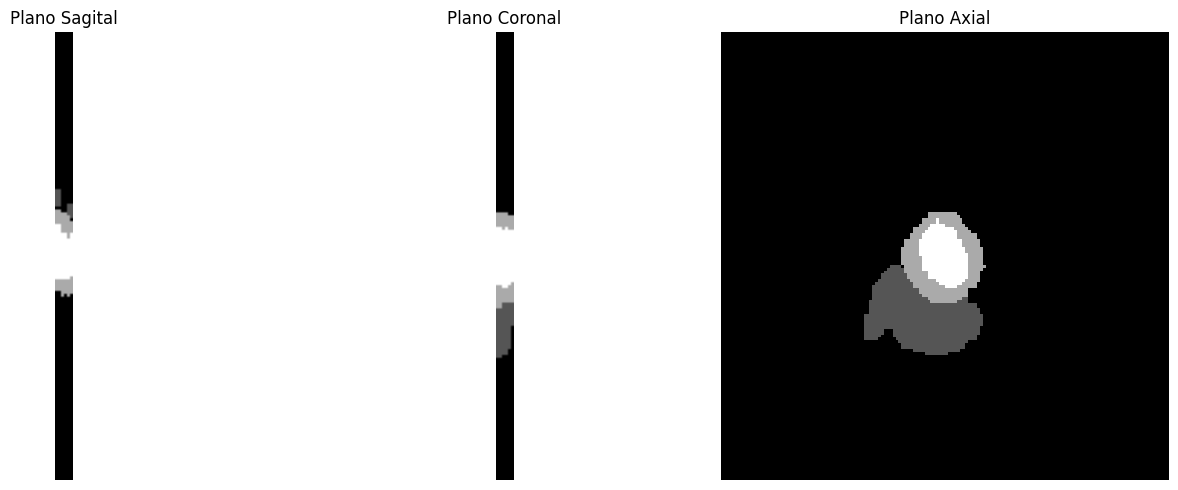

In [13]:
check_data = next(iter(train_loader))
image_tensor = check_data['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento cargada, tamaño: {image_tensor.shape}")

# Las dimensiones son (batch, channel, width, height, depth)

width_idx = image_tensor.size(2) // 2 # Sagittal
height_idx = image_tensor.size(3) // 2 # Coronal
depth_idx = image_tensor.size(4) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal = image_tensor[0, 0, width_idx, :, :]
axs[0].imshow(image_slice_sagittal.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal = image_tensor[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial = image_tensor[0, 0, :, :, depth_idx]
axs[2].imshow(image_slice_axial.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

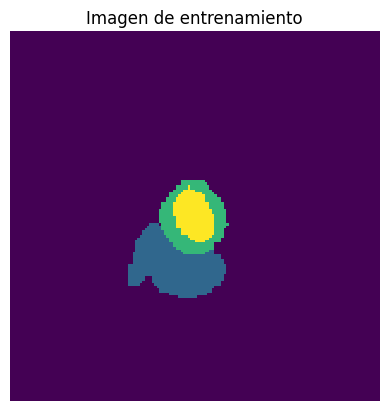

In [14]:
slice_idx = image_tensor.size(4) // 2
#image_slice = image_tensor[0, 0, :, :, slice_idx]
image_slice = image_tensor[0, :, :, :, slice_idx]

# Convertir el tensor en una imagen para visualizar con matplotlib
# plt.imshow(image_slice.cpu().numpy(), cmap='gray')
plt.imshow(image_slice.permute(1, 2, 0).cpu().numpy(), interpolation='none')
plt.title("Imagen de entrenamiento")
plt.axis('off')  # Oculta los ejes
plt.show()

## Define the network

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [16]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=2, padding=1),  # [1, 154, 154, 6] -> [16, 77, 77, 3]
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),  # [16, 77, 77, 3] -> [32, 39, 39, 2]
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  # [32, 39, 39, 2] -> [64, 20, 20, 1]
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=2, padding=1),  # [64, 20, 20, 1] -> [64, 10, 10, 1] 
        )
        
        # Cálculo de la salida del encoder
        # El tamaño después del encoder será [64, 10, 10, 1], entonces la capa FC debe recibir esta entrada.
        self.fc = nn.Linear(64 * 10 * 10 * 1, 64)  # Ajuste según el tamaño de la salida del encoder
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64, 10, 10, 1] -> [64, 20, 20, 2]
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64, 20, 20, 2] -> [32, 40, 40, 4]
            nn.ReLU(),
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32, 40, 40, 4] -> [16, 80, 80, 8]
            nn.ReLU(),
            nn.Conv3d(16, 1, kernel_size=3, padding=1)  # [16, 80, 80, 8] -> [1, 154, 154, 6] (tamaño original)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplanar para el FC
        x = self.fc(x)
        x = x.view(x.size(0), 64, 1, 1, 1)  # Reshape para el decoder
        x = self.decoder(x)
        return x

# Crear el modelo y verificar la salida
model = Autoencoder().to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (5): ReLU()
    (6): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  )
  (fc): Linear(in_features=6400, out_features=64, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (1): ReLU()
    (2): ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (3): ReLU()
    (4): ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (5): ReLU()
    (6): Conv3d(16, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
 

In [20]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.MSELoss()

# Entrenamiento
num_epochs = 20
val_interval = 2  # Cada cuántos epochs se evalúa en validación
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch_data in tqdm(train_loader):
        inputs = batch_data["image"].to(device)
        outputs = model(inputs)
        
        # Usar MSELoss para la comparación entre entradas y salidas
        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
    
    # Validación
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:10<00:00, 19.11it/s]


Epoch [1/20], Train Loss: 0.0974


100%|██████████| 200/200 [00:10<00:00, 19.37it/s]


Epoch [2/20], Train Loss: 0.0812
Epoch [2/20], Validation Loss: 0.0935


100%|██████████| 200/200 [00:10<00:00, 19.35it/s]


Epoch [3/20], Train Loss: 0.0780


100%|██████████| 200/200 [00:10<00:00, 19.36it/s]


Epoch [4/20], Train Loss: 0.0766
Epoch [4/20], Validation Loss: 0.0891


100%|██████████| 200/200 [00:10<00:00, 19.45it/s]


Epoch [5/20], Train Loss: 0.0652


100%|██████████| 200/200 [00:10<00:00, 19.42it/s]


Epoch [6/20], Train Loss: 0.0578
Epoch [6/20], Validation Loss: 0.0624


100%|██████████| 200/200 [00:10<00:00, 19.32it/s]


Epoch [7/20], Train Loss: 0.0523


100%|██████████| 200/200 [00:10<00:00, 19.47it/s]


Epoch [8/20], Train Loss: 0.0428
Epoch [8/20], Validation Loss: 0.0466


100%|██████████| 200/200 [00:10<00:00, 19.45it/s]


Epoch [9/20], Train Loss: 0.0397


100%|██████████| 200/200 [00:10<00:00, 19.42it/s]


Epoch [10/20], Train Loss: 0.0331
Epoch [10/20], Validation Loss: 0.0459


100%|██████████| 200/200 [00:10<00:00, 19.43it/s]


Epoch [11/20], Train Loss: 0.0291


100%|██████████| 200/200 [00:10<00:00, 19.27it/s]


Epoch [12/20], Train Loss: 0.0257
Epoch [12/20], Validation Loss: 0.0335


100%|██████████| 200/200 [00:10<00:00, 19.42it/s]


Epoch [13/20], Train Loss: 0.0211


100%|██████████| 200/200 [00:10<00:00, 19.46it/s]


Epoch [14/20], Train Loss: 0.0217
Epoch [14/20], Validation Loss: 0.0332


100%|██████████| 200/200 [00:10<00:00, 19.40it/s]


Epoch [15/20], Train Loss: 0.0194


100%|██████████| 200/200 [00:10<00:00, 19.32it/s]


Epoch [16/20], Train Loss: 0.0184
Epoch [16/20], Validation Loss: 0.0318


100%|██████████| 200/200 [00:10<00:00, 19.34it/s]


Epoch [17/20], Train Loss: 0.0170


100%|██████████| 200/200 [00:10<00:00, 19.32it/s]


Epoch [18/20], Train Loss: 0.0159
Epoch [18/20], Validation Loss: 0.0284


100%|██████████| 200/200 [00:10<00:00, 19.22it/s]


Epoch [19/20], Train Loss: 0.0174


100%|██████████| 200/200 [00:10<00:00, 19.43it/s]


Epoch [20/20], Train Loss: 0.0157
Epoch [20/20], Validation Loss: 0.0259


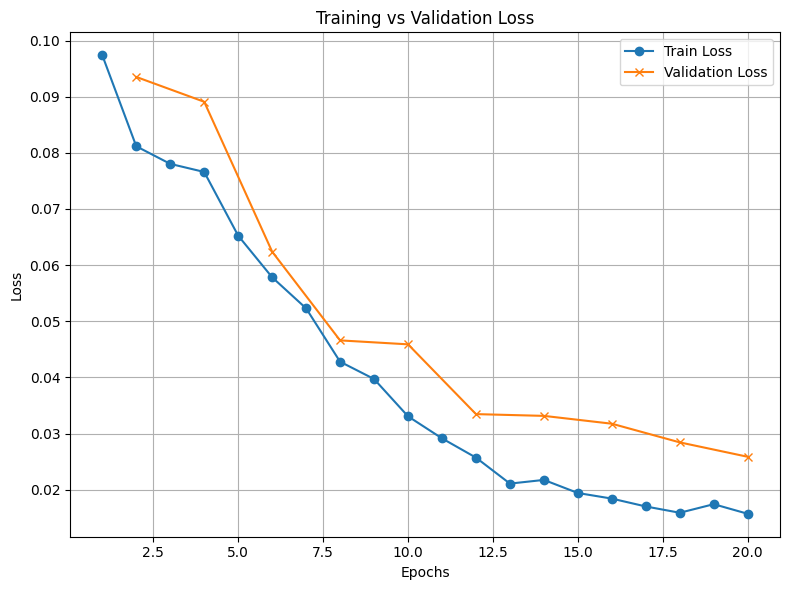

In [21]:
# Visualización de pérdidas
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()